In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数
SEQ_LEN = 30
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.0001
PATIENCE = 10  # 早停的容忍epoch数

import torch
import torch.nn as nn
import math
class PositionalEncoding(nn.Module):
    """位置编码层，注入序列的时序信息"""
    def __init__(self, d_model: int, max_seq_len: int = 5000):
        super().__init__()
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数位置用sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数位置用cos
        self.register_buffer('pe', pe.unsqueeze(0))   # 形状: (1, max_seq_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        输入: x.shape = (batch_size, seq_len, d_model)
        输出: x + pe[:, :seq_len], 形状同输入
        """
        return x + self.pe[:, :x.size(1)]
    


class LSTMTransformerRegressorWithPE(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, nhead=4, num_layers=1, lstm_layers=1):
        super().__init__()
        # LSTM部分
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True)
        
        # 位置编码层
        self.pos_encoder = PositionalEncoding(hidden_dim)
        
        # Transformer部分
        self.embedding = nn.Linear(hidden_dim, hidden_dim)  # 可选的嵌入映射
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 最后的全连接层
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x: (batch, seq_len, input_dim)
        # LSTM处理
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_dim)
        
        # 添加位置编码
        x = self.pos_encoder(lstm_out)  # (batch, seq_len, hidden_dim)
        
        # Transformer处理
        x = self.embedding(x)  # (batch, seq_len, hidden_dim)（可选，可移除）
        x = x.permute(1, 0, 2)  # 调整为Transformer输入格式 (seq_len, batch, hidden_dim)
        x = self.transformer(x)
        x = x[-1]  # 取最后一个时间步的输出 (batch, hidden_dim)
        
        return self.fc(x).squeeze(1)  # (batch)


class TransformerRegressor(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        # 输入嵌入层：将原始特征映射到Transformer的隐藏维度
        self.input_embedding = nn.Linear(input_dim, d_model)
        # 位置编码层
        self.pos_encoder = PositionalEncoding(d_model)
        # Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=4*d_model,  # 遵循原始Transformer设计
            activation='gelu'           # 使用GELU激活函数
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 输出层
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        输入: x.shape = (batch_size, seq_len, input_dim)
        输出: 预测值, 形状 (batch_size)
        """
        # Step 1: 特征嵌入
        x = self.input_embedding(x)  # (batch, seq_len, d_model)
        # Step 2: 添加位置编码
        x = self.pos_encoder(x)     # (batch, seq_len, d_model)
        # Step 3: 调整维度以适应Transformer输入要求 (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)      # (seq_len, batch, d_model)
        # Step 4: 通过Transformer编码器
        x = self.transformer(x)      # (seq_len, batch, d_model)
        # Step 5: 取最后一个时间步的输出
        x = x[-1]                   # (batch, d_model)
        # Step 6: 回归预测
        return self.fc(x).squeeze(1) # (batch)



# 构造序列样本
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 3])  # 预测 Close 价格（即第四列）
    return np.array(X), np.array(y)

# 训练函数
def train_model(X, y, model, epochs=EPOCHS, patience=PATIENCE):
    model = model
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 早停的初始化
    best_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # 早停的检查
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}.")
                break
    
    # 恢复最佳模型
    model.load_state_dict(best_model_state)
    return model



# 预测函数
def predict(model, X):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor)
    return preds.cpu().numpy()

# 使用 Yahoo Finance 加载数据（包含 Open, High, Low, Close）
def load_stock_data(ticker='AAPL', start='2010-01-01', end='2023-01-01'):
    df = yf.download(ticker, start=start, end=end)
    return df[['Open', 'High', 'Low', 'Close']].dropna().values  # 包括多个特征

# 数据加载 + 预处理
prices = load_stock_data(ticker='AAPL')  

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

X, y = create_sequences(scaled_prices, SEQ_LEN)

# 模型训练
model1 = train_model(X, y, TransformerRegressor(input_dim=X.shape[2]).to(device))
model = train_model(X, y, LSTMTransformerRegressorWithPE(input_dim=X.shape[2]).to(device))
# 模型预测
preds = predict(model, X)
preds1 = predict(model1, X)

# 反归一化
true_prices = scaler.inverse_transform(np.hstack((np.zeros((len(y), 3)), y.reshape(-1, 1))))[:, 3]  # 恢复 Close 价格
pred_prices = scaler.inverse_transform(np.hstack((np.zeros((len(preds), 3)), preds.reshape(-1, 1))))[:, 3]

# 评估指标
mae = mean_absolute_error(true_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
r2 = r2_score(true_prices, pred_prices)

print("\n 评估结果:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R^2  = {r2:.4f}")

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Price', color='blue')
plt.plot(pred_prices, label='Predicted Price', color='orange')
plt.title('Actual vs. Predicted Stock Prices ')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
c:\Users\12035\anaconda3\envs\pytorch-gpu-fix\Lib\site-packages\torch\nn\modules\transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.0413
Epoch 2/100, Loss: 0.0087
Epoch 3/100, Loss: 0.0060
Epoch 4/100, Loss: 0.0043
Epoch 5/100, Loss: 0.0035
Epoch 6/100, Loss: 0.0029
Epoch 7/100, Loss: 0.0025
Epoch 8/100, Loss: 0.0021
Epoch 9/100, Loss: 0.0020
Epoch 10/100, Loss: 0.0016
Epoch 11/100, Loss: 0.0016
Epoch 12/100, Loss: 0.0014
Epoch 13/100, Loss: 0.0013
Epoch 14/100, Loss: 0.0012
Epoch 15/100, Loss: 0.0011
Epoch 16/100, Loss: 0.0011
Epoch 17/100, Loss: 0.0011
Epoch 18/100, Loss: 0.0009
Epoch 19/100, Loss: 0.0009
Epoch 20/100, Loss: 0.0009
Epoch 21/100, Loss: 0.0008
Epoch 22/100, Loss: 0.0007
Epoch 23/100, Loss: 0.0007
Epoch 24/100, Loss: 0.0007
Epoch 25/100, Loss: 0.0007
Epoch 26/100, Loss: 0.0007
Epoch 27/100, Loss: 0.0006
Epoch 28/100, Loss: 0.0006
Epoch 29/100, Loss: 0.0006
Epoch 30/100, Loss: 0.0005
Epoch 31/100, Loss: 0.0005
Epoch 32/100, Loss: 0.0005
Epoch 33/100, Loss: 0.0005
Epoch 34/100, Loss: 0.0005
Epoch 35/100, Loss: 0.0005
Epoch 36/100, Loss: 0.0004
Epoch 37/100, Loss: 0.0004
Epoch 38/1

NameError: name 'model2' is not defined


 评估结果:
MAE  = 2.6316
RMSE = 2.8726
R^2  = 0.9963


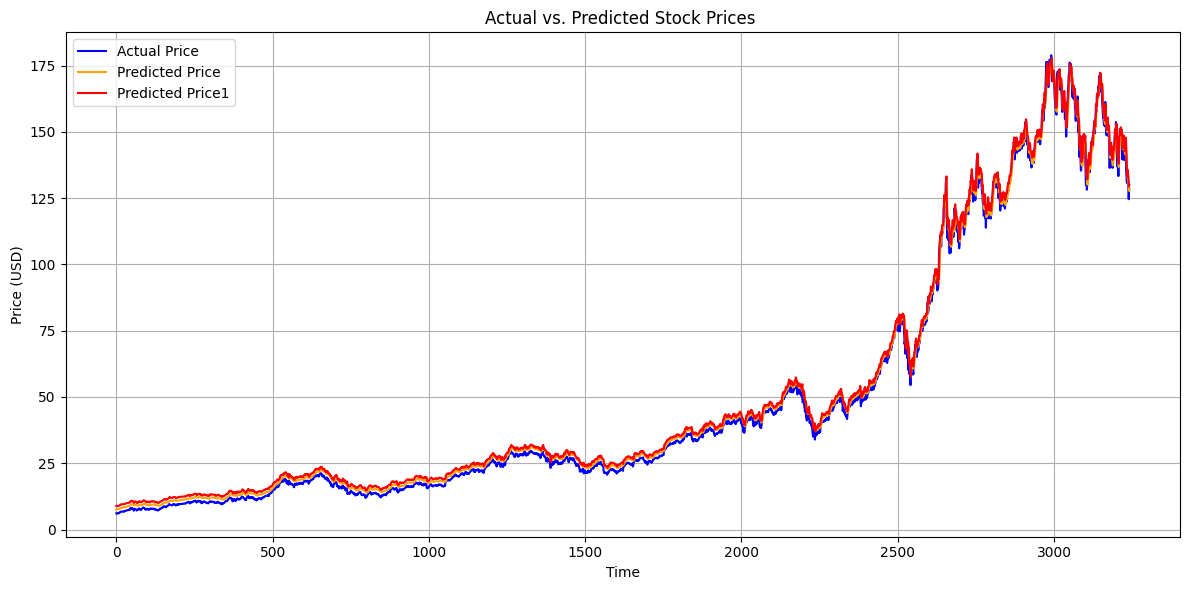

In [4]:
true_prices = scaler.inverse_transform(np.hstack((np.zeros((len(y), 3)), y.reshape(-1, 1))))[:, 3]  # 恢复 Close 价格
pred_prices = scaler.inverse_transform(np.hstack((np.zeros((len(preds), 3)), preds.reshape(-1, 1))))[:, 3]

# 评估指标
mae = mean_absolute_error(true_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
r2 = r2_score(true_prices, pred_prices)
pred_prices1 = scaler.inverse_transform(np.hstack((np.zeros((len(preds1), 3)), preds1.reshape(-1, 1))))[:, 3]

mae1 = mean_absolute_error(true_prices, pred_prices1)
rmse1 = np.sqrt(mean_squared_error(true_prices, pred_prices1))
r21 = r2_score(true_prices, pred_prices1)

print("\n 评估结果:")
print(f"MAE  = {mae1:.4f}")
print(f"RMSE = {rmse1:.4f}")
print(f"R^2  = {r21:.4f}")

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Price', color='blue')
plt.plot(pred_prices, label='Predicted Price', color='orange')
plt.plot(pred_prices1, label='Predicted Price1', color='red')
plt.title('Actual vs. Predicted Stock Prices ')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=2):
        """
        LSTM回归模型
        :param input_dim: 输入特征维度 (e.g. 4个价格特征)
        :param hidden_dim: LSTM隐藏层维度 (与Transformer的d_model对齐)
        :param num_layers: LSTM层数 (默认为1层)
        """
        super().__init__()
        # 输入特征嵌入层（与Transformer对齐）
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True  # 输入格式为(batch, seq_len, features)
        )
        
        # Dropout层防止过拟合
        self.dropout = nn.Dropout(0.2)
        
        # 输出层
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        输入: x.shape = (batch_size, seq_len, input_dim)
        输出: 预测值, 形状 (batch_size)
        """
        # Step 1: 特征嵌入
        x = self.input_embedding(x)  # (batch, seq_len, hidden_dim)
        
        # Step 2: 通过LSTM层
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_dim)
        
        # Step 3: 取最后一个时间步的输出
        x = lstm_out[:, -1, :]  # (batch, hidden_dim)
        
        # Step 4: Dropout正则化
        x = self.dropout(x)
        
        # Step 5: 回归预测
        return self.fc(x).squeeze(1)  # (batch)

model2 = train_model(X, y, LSTMRegressor(input_dim=X.shape[2]).to(device))
preds2 = predict(model2, X)
pred_prices2 = scaler.inverse_transform(np.hstack((np.zeros((len(preds2), 3)), preds2.reshape(-1, 1))))[:, 3]

mae2 = mean_absolute_error(true_prices, pred_prices2)
rmse2 = np.sqrt(mean_squared_error(true_prices, pred_prices2))
r22 = r2_score(true_prices, pred_prices2)

print("\n 评估结果:")
print(f"MAE  = {mae2:.4f}")
print(f"RMSE = {rmse2:.4f}")
print(f"R^2  = {r22:.4f}")


Epoch 1/100, Loss: 0.0704
Epoch 2/100, Loss: 0.0022
Epoch 3/100, Loss: 0.0018
Epoch 4/100, Loss: 0.0018
Epoch 5/100, Loss: 0.0016
Epoch 6/100, Loss: 0.0015
Epoch 7/100, Loss: 0.0015
Epoch 8/100, Loss: 0.0014
Epoch 9/100, Loss: 0.0014
Epoch 10/100, Loss: 0.0012
Epoch 11/100, Loss: 0.0012
Epoch 12/100, Loss: 0.0012
Epoch 13/100, Loss: 0.0012
Epoch 14/100, Loss: 0.0011
Epoch 15/100, Loss: 0.0011
Epoch 16/100, Loss: 0.0011
Epoch 17/100, Loss: 0.0012
Epoch 18/100, Loss: 0.0010
Epoch 19/100, Loss: 0.0011
Epoch 20/100, Loss: 0.0010
Epoch 21/100, Loss: 0.0010
Epoch 22/100, Loss: 0.0010
Epoch 23/100, Loss: 0.0009
Epoch 24/100, Loss: 0.0010
Epoch 25/100, Loss: 0.0010
Epoch 26/100, Loss: 0.0010
Epoch 27/100, Loss: 0.0009
Epoch 28/100, Loss: 0.0009
Epoch 29/100, Loss: 0.0009
Epoch 30/100, Loss: 0.0009
Epoch 31/100, Loss: 0.0009
Epoch 32/100, Loss: 0.0009
Epoch 33/100, Loss: 0.0009
Epoch 34/100, Loss: 0.0009
Epoch 35/100, Loss: 0.0009
Epoch 36/100, Loss: 0.0009
Epoch 37/100, Loss: 0.0009
Epoch 38/1

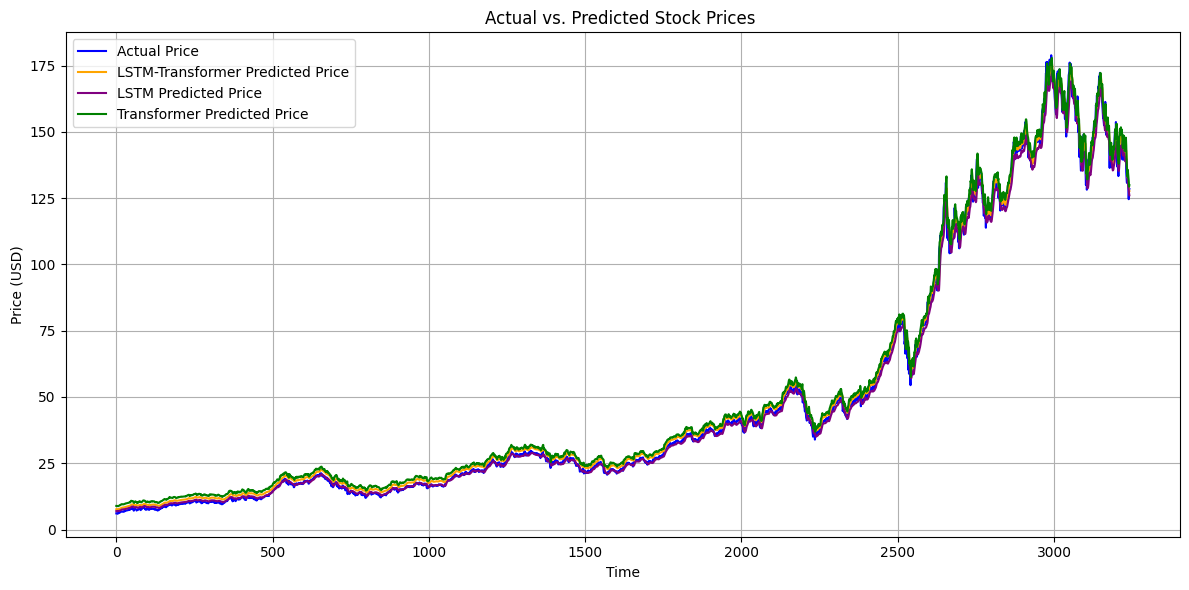

In [7]:

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Price', color='blue')
plt.plot(pred_prices, label='LSTM-Transformer Predicted Price', color='orange')
plt.plot(pred_prices2, label='LSTM Predicted Price', color='purple')
plt.plot(pred_prices1, label='Transformer Predicted Price', color='green')
plt.title('Actual vs. Predicted Stock Prices ')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()